<a href="https://colab.research.google.com/github/SamQuinto/Negotiations-as-Search/blob/main/Negotiations_Analysis_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTANT: In every new runtime, install these THEN restart runtime. When run again, remember to comment all of this out.
!pip install igraph
!apt install libcairo2-dev
!pip install pycairo
!pip install matplotlib-venn

import os
os.kill(os.getpid(), 9)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm  # Use this import for Jupyter Notebook
import warnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# SETUP

In [ ]:
#Import libraries and use appropriate file path (if you havent yet because you skipped to this part of the code)
import pandas as pd
import numpy as np
import itertools
import os
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm  # Use this import for Jupyter Notebook
import warnings

# path = '/content/drive/MyDrive/@Negotiations as Problem Solving/Negotiations_Analysis'
path = '/content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis'


# Let us Check if user of code is currently in Google Colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    # Path in Google Colab
    base_path = path
    input_path = os.path.join(base_path, 'INPUTS_csv')
    output_path = os.path.join(base_path, 'OUTPUTS_csv')
    print(f"You are running this in Google Colab. Your paths are set as follows:")
    print(f"Base path: {base_path}")
    # print(f"Input path: {input_path}") #Intput path is the Output folder
    print(f"Output path: {output_path}")
else:
    # Local path
    base_path = '.'  # Default to current directory
    input_path = os.path.join(base_path, 'INPUTS_csv')
    output_path = os.path.join(base_path, 'OUTPUTS_csv')
    print("You are running this locally. The paths are set as follows:")
    print(f"Base path: {base_path}")
    # print(f"Input path: {input_path}") #Intput path is the Output folder
    print(f"Output path: {output_path}")
    print("If your data files are not in these directories, please modify the paths accordingly.")
os.chdir(base_path)

You are running this in Google Colab. Your paths are set as follows:
Base path: /content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis
Output path: /content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis/OUTPUTS_csv


# START

In [ ]:
# Parties and Issues
N = 10  # Number of parties
M = 5 # Number of Issues

""" Primary Variables of Interest """
P = 0.5 #Compatability
W = 0.5 #Integrative Potential
C = 0.0 #Distributive Potential / negotiator's surplus

# C Scaling
H = 1 + C #payoff for priority issues + C
L = -(W*H) + C #payoff for non-priority issues + C

# State vectorized values for Reservation Price and Target Price
RP = 0
TP = 2

In [ ]:
###########################
# Generate Payoff Matrix
S = np.random.binomial(1, P, (M, N))
U = np.where(S == 1, H, L)
payoff = U

# Transforming to DataFrame
columns = [f"Party_{i + 1}" for i in range(N)]
index = [f"Issue_{j + 1}" for j in range(M)]

df_payoff = pd.DataFrame(payoff, columns=columns, index=index)

#Generate main df
df_payoff.loc["reservation"] = [RP] * N
df_payoff.loc["target"] = [TP] * N

# Creating the option column and duplicating each issue row
df_payoff.reset_index(inplace=True)
df_payoff.rename(columns={'index': 'issue'}, inplace=True)
priority_df = df_payoff.copy()
priority_df['option'] = 'priority'
not_priority_df = df_payoff.copy()
not_priority_df['option'] = 'non_priority'
not_priority_df.update(not_priority_df[columns].applymap(lambda x: 0))

# Excluding 'non_priority' rows for 'reservation' and 'target' and setting 'option' to 'N/A' for these rows
priority_df.loc[priority_df['issue'].isin(['reservation', 'target']), 'option'] = 'N/A'
not_priority_df = not_priority_df[~not_priority_df['issue'].isin(['reservation', 'target'])]

# Concatenating priority and non_priority DataFrames
df_expanded = pd.concat([priority_df, not_priority_df])

# Sorting the DataFrame
df_expanded.sort_values(by=['issue', 'option'], ascending=[True, False], inplace=True)

# Reordering columns
columns_reordered = ['issue', 'option'] + [col for col in df_expanded.columns if col not in ['issue', 'option']]
df_expanded = df_expanded[columns_reordered]

# Resetting the index
df_expanded.reset_index(drop=True, inplace=True)

import pandas as pd
from itertools import product

# Assuming df_expanded is already defined

# Strip whitespace from column names
df_expanded.columns = df_expanded.columns.str.strip()

# Assign 'issue' and 'option' based on column index
issue_col_index = 0
option_col_index = 1
issue_col_name = df_expanded.columns[issue_col_index]
option_col_name = df_expanded.columns[option_col_index]

# Remaining columns are considered party names
parties = df_expanded.columns[2:].tolist()

# Identify indices for 'Reservation' and 'Target' rows
reservation_idx = df_expanded.index[df_expanded[issue_col_name] == 'reservation'].tolist()
target_idx = df_expanded.index[df_expanded[issue_col_name] == 'target'].tolist()

# Save 'Reservation' and 'Target' rows for appending later
reservation_row = df_expanded.loc[reservation_idx]
target_row = df_expanded.loc[target_idx]

# Remove 'Reservation' and 'Target' rows for processing
rows_to_remove = reservation_idx + target_idx
df_expanded.drop(rows_to_remove, inplace=True)

# Generate 'option-issue code'
df_expanded['option-issue code'] = df_expanded.groupby(issue_col_name).cumcount() + 1

# Convert 'option-issue code' to integer
df_expanded['option-issue code'] = df_expanded['option-issue code'].astype(int)

# Get unique issues and map them to issue codes
unique_issues = df_expanded[issue_col_name].unique()
issue_to_code = {issue: code for code, issue in enumerate(unique_issues, start=1)}
df_expanded['issue code'] = df_expanded[issue_col_name].map(issue_to_code).astype('Int64', errors='ignore')

# Reorder columns
cols = [issue_col_name, 'issue code', option_col_name, 'option-issue code'] + parties
df_expanded = df_expanded[cols]

# Append 'Reservation' and 'Target' rows back to the DataFrame
df_expanded = pd.concat([df_expanded, reservation_row, target_row], ignore_index=True)


#CONTINUATION
# Extract the reservation and target prices
reservation_df = df_expanded.iloc[-2]
target_df = df_expanded.iloc[-1]

# Filter out the reservation and target rows for combination analysis
dfn_filtered = df_expanded.iloc[:-2].copy()
dfn_filtered.sort_values(['issue code', 'option-issue code'], inplace=True)

# Generate combinations of proposals
issues = dfn_filtered['issue code'].unique()
options_by_issue = {issue: dfn_filtered[dfn_filtered['issue code'] == issue]['option-issue code'].astype(int).tolist() for issue in issues}
all_combinations = list(product(*options_by_issue.values()))

new_df = pd.DataFrame(all_combinations, columns=issues)
new_df['proposal'] = new_df.apply(lambda row: ''.join(str(int(v)) for v in row), axis=1)

# Function to calculate payoffs
def calculate_payoff(party, proposal):
    payoffs = [dfn_filtered[(dfn_filtered['issue code'] == issue) & (dfn_filtered['option-issue code'] == int(option))][party].values[0]
                for issue, option in zip(issues, proposal)]
    return sum(payoffs)

# Calculate payoffs and reservation/target met for each party
for party in parties:
    new_df[f'{party}_payoff'] = new_df['proposal'].apply(lambda x: calculate_payoff(party, x))
    new_df[f'{party}_meets_reservation'] = new_df[f'{party}_payoff'] >= reservation_df[party]
    new_df[f'{party}_meets_target'] = new_df[f'{party}_payoff'] >= target_df[party]

# Calculate joint payoff and voting summary
new_df['joint_payoff'] = new_df['proposal'].apply(lambda x: sum(calculate_payoff(party, x) for party in parties))
new_df['Votes'] = new_df[[f'{party}_meets_reservation' for party in parties]].sum(axis=1)
new_df['Left Out'] = new_df.apply(lambda row: ', '.join([party for party in parties if not row[f'{party}_meets_reservation']]), axis=1)
new_df['Targets Reached'] = new_df[[f'{party}_meets_target' for party in parties]].sum(axis=1)

# Reorder columns
cols = ['proposal', 'joint_payoff', 'Votes', 'Left Out', 'Targets Reached'] + \
       [f"{party}_payoff" for party in parties] + \
       [f"{party}_meets_reservation" for party in parties] + \
       [f"{party}_meets_target" for party in parties]
df_expanded = new_df[cols]

###
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import csv

# Assume df_expanded (or new_df in your original code) is your existing DataFrame and parties is defined

# Create a dictionary for quick lookup of proposal data
proposal_data = {
    row['proposal']: {
        'payoffs': {party: row[f'{party}_payoff'] for party in parties},
        'votes': row['Votes']
    }
    for _, row in df_expanded.iterrows()
}

proposals = df_expanded['proposal'].unique()
transitions = list(product(proposals, repeat=2))

# Create a DataFrame to store transition data
transition_columns = ['Origin', 'Destination', 'Origin_payoff', 'Destination_payoff', 'Origin_votes', 'Destination_votes', 'Transition', 'Worse_Off']
transition_df = pd.DataFrame(columns=transition_columns)


# Populate the DataFrame
for origin, destination in transitions:
    origin_data = proposal_data[origin]['payoffs']
    destination_data = proposal_data[destination]['payoffs']
    origin_payoff = sum(origin_data.values())
    destination_payoff = sum(destination_data.values())
    origin_votes = proposal_data[origin]['votes']
    destination_votes = proposal_data[destination]['votes']
    transition = f"{origin}_{destination}"

    # Check for Pareto optimality
    worse_off_parties = [party for party in parties if destination_data[party] < origin_data[party]]
    pareto_optimal = "None" if not worse_off_parties else ", ".join(worse_off_parties)

    transition_row = [origin, destination, origin_payoff, destination_payoff, origin_votes, destination_votes, transition, pareto_optimal]
    transition_df.loc[len(transition_df)] = transition_row

#REMOVE Duplicates
transition_df = transition_df[transition_df['Origin'] != transition_df['Destination']]

# Initialize a new DataFrame to store the analysis results
nego_df = transition_df.copy()

# Convert 'Origin' and 'Destination' to strings if they are not already
nego_df['Origin'] = nego_df['Origin'].astype(str)
nego_df['Destination'] = nego_df['Destination'].astype(str)

# Initialize lists to hold DataFrame rows for new columns
payoff_changes = []
vote_changes = []
option_changes = []
distances = []

# Populate new columns
for idx, row in nego_df.iterrows():
    # Existing columns
    payoff_changes.append(row['Destination_payoff'] - row['Origin_payoff'])
    vote_changes.append(row['Destination_votes'] - row['Origin_votes'])
    changes = sum(o != d for o, d in zip(row['Origin'], row['Destination']))
    option_changes.append(changes)
    origin_vector = np.array([int(x) for x in row['Origin']])
    destination_vector = np.array([int(x) for x in row['Destination']])
    distance = np.linalg.norm(origin_vector - destination_vector)
    distances.append(distance)

# Add new columns to nego_df
nego_df['Payoff_Change'] = payoff_changes
nego_df['Vote_Change'] = vote_changes
nego_df['Option_Change'] = option_changes
nego_df['Distance'] = distances

# Re-organize columns
columns_order = ['Transition', 'Payoff_Change', 'Vote_Change', 'Option_Change', 'Distance'] + [col for col in nego_df.columns if col not in ['Transition', 'Payoff_Change', 'Vote_Change', 'Option_Change', 'Distance']]
nego_df = nego_df[columns_order]

# Compute Max Distance
def calc_max_distance(row):
    origin = [int(x) for x in row['Origin']]
    destination = [int(x) for x in row['Destination']]
    return max([abs(o - d) for o, d in zip(origin, destination)])

nego_df['Max Distance'] = nego_df.apply(calc_max_distance, axis=1)


# Define the threshold for agreement
agreement_threshold = max(nego_df['Origin_votes'])
# Generate new columns based on the threshold
nego_df['Origin_Agreement'] = (nego_df['Origin_votes'] >= agreement_threshold).astype(int)
nego_df['Destination_Agreement'] = (nego_df['Destination_votes'] >= agreement_threshold).astype(int)

################
# Define Transition Rule (Transition Rule legend)
def apply_transition_rules_to_dataframe(df, rule_number):
    '''
    Applies specified transition rules to the DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame on which to apply the transition rules.
    rule_number (int): The number of the transition rule to apply.

    Rules:
    1. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Payoff_Change' is strictly positive.
    2. Keep rows only if 'Payoff_Change' is strictly positive.
    3. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Worse_Off' is 'None'.
    '''

    # Ensure the rule_number is valid
    if rule_number not in [1, 2, 3]:
        raise ValueError('Invalid rule number. Please select 1, 2, or 3.')

    # Define the conditions for keeping rows based on the rule
    if rule_number == 1:
        condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Payoff_Change'] > 0))
    elif rule_number == 2:
        condition = df['Payoff_Change'] >= 0
    elif rule_number == 3:
        # Pareto Optimality rule
        condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Worse_Off'] == 'None'))

    # Filter the DataFrame based on the condition
    filtered_df = df[condition]

    return filtered_df
###
nego_df

<ipython-input-6-2fba569d3c73>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  not_priority_df.update(not_priority_df[columns].applymap(lambda x: 0))
<ipython-input-6-2fba569d3c73>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nego_df['Max Distance'] = nego_df.apply(calc_max_distance, axis=1)
<ipython-input-6-2fba569d3c73>:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nego_df['Origin_Agreement'] = (nego_df['Origin_votes'] >= agreement_threshold).astype(int)


,Transition,Payoff_Change,Vote_Change,Option_Change,Distance,Origin,Destination,Origin_payoff,Destination_payoff,Origin_votes,Destination_votes,Worse_Off,Max Distance,Origin_Agreement,Destination_Agreement
1,11111_11112,-1.0,-1,1,1.000000,11111,11112,9.5,8.5,7,6,"Party_1, Party_3, Party_6, Party_8",1,0,0
2,11111_11121,-5.5,-1,1,1.000000,11111,11121,9.5,4.0,7,6,"Party_1, Party_2, Party_3, Party_4, Party_5, P...",1,0,0
3,11111_11122,-6.5,1,2,1.414214,11111,11122,9.5,3.0,7,8,"Party_1, Party_2, Party_3, Party_4, Party_5, P...",1,0,0
4,11111_11211,-2.5,-2,1,1.000000,11111,11211,9.5,7.0,7,5,"Party_1, Party_6, Party_7, Party_8, Party_9",1,0,0
5,11111_11212,-3.5,1,2,1.414214,11111,11212,9.5,6.0,7,8,"Party_1, Party_3, Party_6, Party_7, Party_8, P...",1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,22222_22121,3.5,-4,2,1.414214,22222,22121,0.0,3.5,10,6,"Party_2, Party_4, Party_5, Party_10",1,1,0
1019,22222_22122,2.5,-5,1,1.000000,22222,22122,0.0,2.5,10,5,"Party_2, Party_3, Party_4, Party_5, Party_10",1,1,0
1020,22222_22211,6.5,-2,2,1.414214,22222,22211,0.0,6.5,10,8,"Party_7, Party_9",1,1,0
1021,22222_22212,5.5,-3,1,1.000000,22222,22212,0.0,5.5,10,7,"Party_6, Party_7, Party_9",1,1,0


# MID: Define Transition Rule and Agreement Rule, then calculate for local peaks

In [ ]:
#Choose Transition Rule
Chosen_Rule = 3

# Apply Transition Rule
filtered_df = apply_transition_rules_to_dataframe(nego_df, rule_number=Chosen_Rule)

# post-process and preview
column_order = ['Origin', 'Destination'] + [col for col in filtered_df if col not in ['Origin', 'Destination']]
filtered_df = filtered_df[column_order]
#Create Agreement counter
filtered_df['Reached Consensus'] = filtered_df['Destination_Agreement'].apply(lambda x: 'Y' if x == 1 else 'N')
filtered_df

# Apply Myopic Filter
myopic_df = filtered_df[filtered_df['Option_Change'] == 1]

# Create Agreement Counter
myopic_df['Reached Consensus'] = myopic_df['Destination_Agreement'].apply(lambda x: 'Y' if x == 1 else 'N')

# Initialize variables for counts
number_of_agreement_nodes = 0
number_of_local_peaks = 0
direct_leads_to_local_peaks = 0

# Logic to calculate 'number_of_agreement_nodes' and 'number_of_local_peaks'
G_temp = ig.Graph.TupleList(
    [tuple(x) for x in myopic_df[['Origin', 'Destination']].to_records(index=False)],
    directed=True,
    vertex_name_attr='name'
)

# Identify local peaks that are not agreement nodes
local_peaks_temp = [v.index for v in G_temp.vs if G_temp.degree(v, mode="out") == 0]
unique_consensus_nodes = myopic_df[myopic_df['Reached Consensus'] == 'Y']['Destination'].unique().tolist()
non_agreement_local_peaks = [peak for peak in local_peaks_temp if G_temp.vs[peak]['name'] not in unique_consensus_nodes]
local_peak_names = [G_temp.vs[v]['name'] for v in non_agreement_local_peaks]


# Initialize a set to store nodes leading to local peaks
nodes_leading_to_local_peaks = set()
# Count the nodes that reached consensus
number_of_agreement_nodes = len(unique_consensus_nodes)
# Count the local peaks that are not agreement nodes
number_of_local_peaks = len(non_agreement_local_peaks)


#####

# Initialize a counter for nodes directly leading to local peaks
direct_leads_to_local_peaks = 0

# Traverse the graph to find nodes directly leading to local peaks
for v in G_temp.vs:
    for peak in non_agreement_local_peaks:
        if G_temp.are_connected(v.index, peak):
            direct_leads_to_local_peaks += 1


# Calculate the Local Peak Influence Ratio
local_peak_influence_ratio = direct_leads_to_local_peaks / len(G_temp.vs) * 100


####
# Initialize a set to store nodes leading to local peaks (including indirect paths)
nodes_leading_to_local_peaks = set()

# Traverse the graph to find nodes leading to local peaks (including indirect paths)
for v in G_temp.vs:
    for peak in non_agreement_local_peaks:
        paths = G_temp.get_all_simple_paths(v, to=peak)
        if any(paths):
            nodes_leading_to_local_peaks.add(v['name'])
            break
# Calculate the basin of attraction percentage
basin_of_attraction_percentage = len(nodes_leading_to_local_peaks) / len(G_temp.vs) * 100

###

# Output the results
print('Number of Agreement Nodes:', number_of_agreement_nodes)
print('Number of Local Peaks (not agreement nodes):', number_of_local_peaks)
print('Basin of Attraction Percentage:', basin_of_attraction_percentage)
print('Local Peak Influence Ratio:', local_peak_influence_ratio)

Number of Agreement Nodes: 5
Number of Local Peaks (not agreement nodes): 8
Basin of Attraction Percentage: 59.375
Local Peak Influence Ratio: 115.625


<ipython-input-7-66a1ebeaed8b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myopic_df['Reached Consensus'] = myopic_df['Destination_Agreement'].apply(lambda x: 'Y' if x == 1 else 'N')
<ipython-input-7-66a1ebeaed8b>:55: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if G_temp.are_connected(v.index, peak):


## Graphing

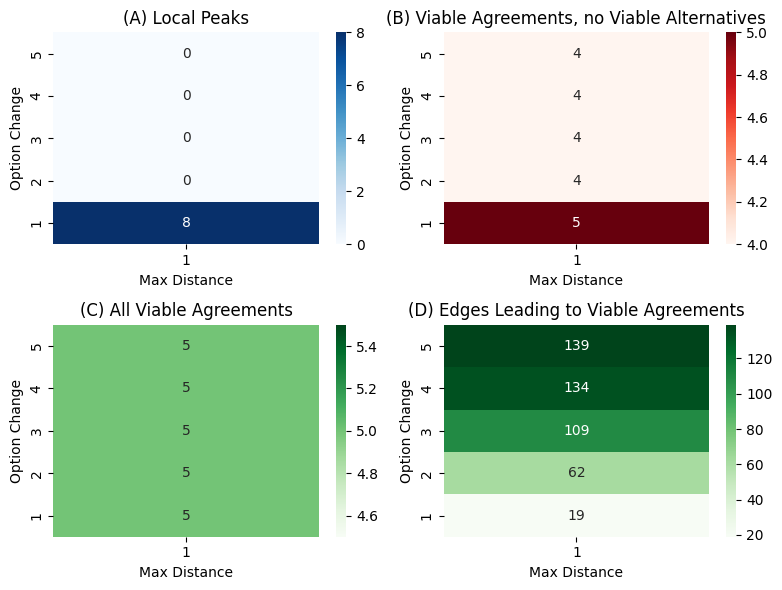

In [ ]:
# Determine the maximum values for 'Option_Change' and 'Max Distance'
max_opt_change = filtered_df['Option_Change'].max()
max_max_dist = filtered_df['Max Distance'].max()

# Initialize matrices
local_peaks_matrix = np.zeros((max_opt_change, max_max_dist), dtype=int)
consensus_matrix = np.zeros((max_opt_change, max_max_dist), dtype=int)
viable_agreements_matrix = np.zeros((max_opt_change, max_max_dist), dtype=int)
edges_matrix = np.zeros((max_opt_change, max_max_dist), dtype=int)

for opt_change in range(1, max_opt_change + 1):
    for max_dist in range(1, max_max_dist + 1):
        temp_df = filtered_df[
            (filtered_df['Option_Change'] <= opt_change) &
            (filtered_df['Max Distance'] <= max_dist)
        ]

        G_temp = ig.Graph.TupleList(
            [tuple(x) for x in temp_df[['Origin', 'Destination']].to_records(index=False)],
            directed=True,
            vertex_name_attr='name'
        )

        # Identify nodes that reached consensus
        consensus_nodes = temp_df[temp_df['Reached Consensus'] == 'Y']['Destination'].unique()

        # Identify local peaks (excluding consensus nodes)
        local_peaks_temp = [v.index for v in G_temp.vs
                            if G_temp.degree(v, mode="out") == 0 and
                            v['name'] not in consensus_nodes]

        # Identify viable agreements (consensus nodes with out-degree = 0)
        viable_agreements = [v.index for v in G_temp.vs
                             if v['name'] in consensus_nodes and
                             G_temp.degree(v, mode="out") == 0]

        # Count the nodes that reached consensus within the current subgraph
        consensus_nodes_count = len(consensus_nodes)

        # Count the edges that lead to agreement
        edges_to_agreement_count = len(temp_df[temp_df['Reached Consensus'] == 'Y'])

        # Fill matrices
        local_peaks_matrix[opt_change-1, max_dist-1] = len(local_peaks_temp)
        consensus_matrix[opt_change-1, max_dist-1] = consensus_nodes_count
        viable_agreements_matrix[opt_change-1, max_dist-1] = len(viable_agreements)
        edges_matrix[opt_change-1, max_dist-1] = edges_to_agreement_count

# Create DataFrames for heatmaps
df_local_peaks = pd.DataFrame(local_peaks_matrix, index=range(1, max_opt_change + 1), columns=range(1, max_max_dist + 1))
df_agreement = pd.DataFrame(consensus_matrix, index=range(1, max_opt_change + 1), columns=range(1, max_max_dist + 1))
df_viable_agreements = pd.DataFrame(viable_agreements_matrix, index=range(1, max_opt_change + 1), columns=range(1, max_max_dist + 1))
df_edges = pd.DataFrame(edges_matrix, index=range(1, max_opt_change + 1), columns=range(1, max_max_dist + 1))

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(df_local_peaks.iloc[::-1], annot=True, cmap='Blues', fmt='d', ax=axes[0, 0])
axes[0, 0].set_title("(A) Local Peaks")
axes[0, 0].set_xlabel("Max Distance")
axes[0, 0].set_ylabel("Option Change")

sns.heatmap(df_viable_agreements.iloc[::-1], annot=True, cmap='Reds', fmt='d', ax=axes[0, 1])
axes[0, 1].set_title("(B) Viable Agreements, no Viable Alternatives")
axes[0, 1].set_xlabel("Max Distance")
axes[0, 1].set_ylabel("Option Change")


sns.heatmap(df_agreement.iloc[::-1], annot=True, cmap='Greens', fmt='d', ax=axes[1, 0])
axes[1, 0].set_title("(C) All Viable Agreements")
axes[1, 0].set_xlabel("Max Distance")
axes[1, 0].set_ylabel("Option Change")

sns.heatmap(df_edges.iloc[::-1], annot=True, cmap='Greens', fmt='d', ax=axes[1, 1])
axes[1, 1].set_title("(D) Edges Leading to Viable Agreements")
axes[1, 1].set_xlabel("Max Distance")
axes[1, 1].set_ylabel("Option Change")

plt.tight_layout()
plt.show()

#End

#Simulation v3


In [ ]:

def run_simulation(N, M, P, W, C, RP=0, TP=2):
    import pandas as pd
    import numpy as np
    ###########################
    H = 1 + C
    L = -W*H + C

    # Generate Payoff Matrix
    S = np.random.binomial(1, P, (M, N))
    U = np.where(S == 1, H, L)
    payoff = U

    # Transforming to DataFrame
    columns = [f"Party_{i + 1}" for i in range(N)]
    index = [f"Issue_{j + 1}" for j in range(M)]

    df_payoff = pd.DataFrame(payoff, columns=columns, index=index)

    #Generate main df
    df_payoff.loc["reservation"] = [RP] * N
    df_payoff.loc["target"] = [TP] * N

    # Creating the option column and duplicating each issue row
    df_payoff.reset_index(inplace=True)
    df_payoff.rename(columns={'index': 'issue'}, inplace=True)
    priority_df = df_payoff.copy()
    priority_df['option'] = 'include'
    not_priority_df = df_payoff.copy()
    not_priority_df['option'] = 'exclude'
    not_priority_df.update(not_priority_df[columns].applymap(lambda x: 0))

    # Excluding 'non_priority' rows for 'reservation' and 'target' and setting 'option' to 'N/A' for these rows
    priority_df.loc[priority_df['issue'].isin(['reservation', 'target']), 'option'] = 'N/A'
    not_priority_df = not_priority_df[~not_priority_df['issue'].isin(['reservation', 'target'])]

    # Concatenating priority and non_priority DataFrames
    df_expanded = pd.concat([priority_df, not_priority_df])

    # Sorting the DataFrame
    df_expanded.sort_values(by=['issue', 'option'], ascending=[True, False], inplace=True)

    # Reordering columns
    columns_reordered = ['issue', 'option'] + [col for col in df_expanded.columns if col not in ['issue', 'option']]
    df_expanded = df_expanded[columns_reordered]

    # Resetting the index
    df_expanded.reset_index(drop=True, inplace=True)

    ####EXPORT RAW_DF##################
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f'rawdata_P={P}_W={W}_C={round(C,2)}_N={N}_M={M}_{timestamp}'
    output_path = '/content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis/OUTPUTS_csv/M=8_storage consensus/N=5'
    rawdata_export = base_name + '.csv'
    final_path = os.path.join(output_path, rawdata_export)
    df_expanded.to_csv(final_path, index=False)
    ####EXPORT RAW_DF##################

    import pandas as pd
    from itertools import product

    # Strip whitespace from column names
    df_expanded.columns = df_expanded.columns.str.strip()

    # Assign 'issue' and 'option' based on column index
    issue_col_index = 0
    option_col_index = 1
    issue_col_name = df_expanded.columns[issue_col_index]
    option_col_name = df_expanded.columns[option_col_index]

    # Remaining columns are considered party names
    parties = df_expanded.columns[2:].tolist()

    # Identify indices for 'Reservation' and 'Target' rows
    reservation_idx = df_expanded.index[df_expanded[issue_col_name] == 'reservation'].tolist()
    target_idx = df_expanded.index[df_expanded[issue_col_name] == 'target'].tolist()

    # Save 'Reservation' and 'Target' rows for appending later
    reservation_row = df_expanded.loc[reservation_idx]
    target_row = df_expanded.loc[target_idx]

    # Remove 'Reservation' and 'Target' rows for processing
    rows_to_remove = reservation_idx + target_idx
    df_expanded.drop(rows_to_remove, inplace=True)

    # Generate 'option-issue code'
    df_expanded['option-issue code'] = df_expanded.groupby(issue_col_name).cumcount() + 1

    # Convert 'option-issue code' to integer
    df_expanded['option-issue code'] = df_expanded['option-issue code'].astype(int)

    # Get unique issues and map them to issue codes
    unique_issues = df_expanded[issue_col_name].unique()
    issue_to_code = {issue: code for code, issue in enumerate(unique_issues, start=1)}
    df_expanded['issue code'] = df_expanded[issue_col_name].map(issue_to_code).astype('Int64', errors='ignore')

    # Reorder columns
    cols = [issue_col_name, 'issue code', option_col_name, 'option-issue code'] + parties
    df_expanded = df_expanded[cols]

    # Append 'Reservation' and 'Target' rows back to the DataFrame
    df_expanded = pd.concat([df_expanded, reservation_row, target_row], ignore_index=True)

    #CONTINUATION
    # Extract the reservation and target prices
    reservation_df = df_expanded.iloc[-2]
    target_df = df_expanded.iloc[-1]

    # Filter out the reservation and target rows for combination analysis
    dfn_filtered = df_expanded.iloc[:-2].copy()
    dfn_filtered.sort_values(['issue code', 'option-issue code'], inplace=True)

    # Generate combinations of proposals
    issues = dfn_filtered['issue code'].unique()
    options_by_issue = {issue: dfn_filtered[dfn_filtered['issue code'] == issue]['option-issue code'].astype(int).tolist() for issue in issues}
    all_combinations = list(product(*options_by_issue.values()))

    new_df = pd.DataFrame(all_combinations, columns=issues)
    new_df['proposal'] = new_df.apply(lambda row: ''.join(str(int(v)) for v in row), axis=1)

    # Function to calculate payoffs
    def calculate_payoff(party, proposal):
        payoffs = [dfn_filtered[(dfn_filtered['issue code'] == issue) & (dfn_filtered['option-issue code'] == int(option))][party].values[0]
                    for issue, option in zip(issues, proposal)]
        return sum(payoffs)

    # Calculate payoffs and reservation/target met for each party
    for party in parties:
        new_df[f'{party}_payoff'] = new_df['proposal'].apply(lambda x: calculate_payoff(party, x))
        new_df[f'{party}_meets_reservation'] = new_df[f'{party}_payoff'] >= reservation_df[party]
        new_df[f'{party}_meets_target'] = new_df[f'{party}_payoff'] >= target_df[party]

    # Calculate joint payoff and voting summary
    new_df['joint_payoff'] = new_df['proposal'].apply(lambda x: sum(calculate_payoff(party, x) for party in parties))
    new_df['Votes'] = new_df[[f'{party}_meets_reservation' for party in parties]].sum(axis=1)
    new_df['Left Out'] = new_df.apply(lambda row: ', '.join([party for party in parties if not row[f'{party}_meets_reservation']]), axis=1)
    new_df['Targets Reached'] = new_df[[f'{party}_meets_target' for party in parties]].sum(axis=1)

    # Reorder columns
    cols = ['proposal', 'joint_payoff', 'Votes', 'Left Out', 'Targets Reached'] + \
          [f"{party}_payoff" for party in parties] + \
          [f"{party}_meets_reservation" for party in parties] + \
          [f"{party}_meets_target" for party in parties]
    df_expanded = new_df[cols]

    ###
    import pandas as pd
    import numpy as np
    from tqdm.notebook import tqdm
    import csv

    # Assume df_expanded (or new_df in your original code) is your existing DataFrame and parties is defined

    # Create a dictionary for quick lookup of proposal data
    proposal_data = {
        row['proposal']: {
            'payoffs': {party: row[f'{party}_payoff'] for party in parties},
            'votes': row['Votes']
        }
        for _, row in df_expanded.iterrows()
    }

    proposals = df_expanded['proposal'].unique()
    transitions = list(product(proposals, repeat=2))

    # Create a DataFrame to store transition data
    transition_columns = ['Origin', 'Destination', 'Origin_payoff', 'Destination_payoff', 'Origin_votes', 'Destination_votes', 'Transition', 'Worse_Off']
    transition_df = pd.DataFrame(columns=transition_columns)


    # Populate the DataFrame
    for origin, destination in transitions:
        origin_data = proposal_data[origin]['payoffs']
        destination_data = proposal_data[destination]['payoffs']
        origin_payoff = sum(origin_data.values())
        destination_payoff = sum(destination_data.values())
        origin_votes = proposal_data[origin]['votes']
        destination_votes = proposal_data[destination]['votes']
        transition = f"{origin}_{destination}"

        # Check for Pareto optimality
        worse_off_parties = [party for party in parties if destination_data[party] < origin_data[party]]
        pareto_optimal = "None" if not worse_off_parties else ", ".join(worse_off_parties)

        transition_row = [origin, destination, origin_payoff, destination_payoff, origin_votes, destination_votes, transition, pareto_optimal]
        transition_df.loc[len(transition_df)] = transition_row

    #REMOVE Duplicates
    transition_df = transition_df[transition_df['Origin'] != transition_df['Destination']]

    # Initialize a new DataFrame to store the analysis results
    nego_df = transition_df.copy()

    # Convert 'Origin' and 'Destination' to strings if they are not already
    nego_df['Origin'] = nego_df['Origin'].astype(str)
    nego_df['Destination'] = nego_df['Destination'].astype(str)

    # Initialize lists to hold DataFrame rows for new columns
    payoff_changes = []
    vote_changes = []
    option_changes = []
    distances = []

    # Populate new columns
    for idx, row in nego_df.iterrows():
        # Existing columns
        payoff_changes.append(row['Destination_payoff'] - row['Origin_payoff'])
        vote_changes.append(row['Destination_votes'] - row['Origin_votes'])
        changes = sum(o != d for o, d in zip(row['Origin'], row['Destination']))
        option_changes.append(changes)
        origin_vector = np.array([int(x) for x in row['Origin']])
        destination_vector = np.array([int(x) for x in row['Destination']])
        distance = np.linalg.norm(origin_vector - destination_vector)
        distances.append(distance)

    # Add new columns to nego_df
    nego_df['Payoff_Change'] = payoff_changes
    nego_df['Vote_Change'] = vote_changes
    nego_df['Option_Change'] = option_changes
    nego_df['Distance'] = distances

    # Re-organize columns
    columns_order = ['Transition', 'Payoff_Change', 'Vote_Change', 'Option_Change', 'Distance'] + [col for col in nego_df.columns if col not in ['Transition', 'Payoff_Change', 'Vote_Change', 'Option_Change', 'Distance']]
    nego_df = nego_df[columns_order]

    # Compute Max Distance
    def calc_max_distance(row):
        origin = [int(x) for x in row['Origin']]
        destination = [int(x) for x in row['Destination']]
        return max([abs(o - d) for o, d in zip(origin, destination)])

    nego_df['Max Distance'] = nego_df.apply(calc_max_distance, axis=1)


    ####EXPORT NEGO_DF##################
    import datetime
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    base_name = f'transition_rawdata_P={P}_W={W}_C={round(C,2)}_N={N}_M={M}_{timestamp}'
    output_path = '/content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis/OUTPUTS_csv/M=8_storage consensus/N=5'


    final_csv_name_transition_rawdata = base_name + '.csv'
    final_path = os.path.join(output_path, final_csv_name_transition_rawdata)
    nego_df.to_csv(final_path, index=False)

    ###EXPORT###########################


    ## Define Agreement Threshold

    def set_agreement_threshold(nego_df, N, rule_choice):
        """
        Sets the agreement threshold based on the specified rule.

        Parameters:
        nego_df (DataFrame): The negotiation Data.Frame.
        N (int): Number of parties.
        rule_choice (int): The choice of rule.
                          1 for simple majority threshold,
                          2 for max votes minus one.

        Returns:
        DataFrame: The updated negotiation DataFrame with new agreement columns.
        """
        if rule_choice == 1:
            # Majority threshold rule
            majority_threshold = N // 2
            # nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] > majority_threshold) & (nego_df['Origin_veto'] == 'No')).astype(int)
            nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] > majority_threshold)).astype(int)
            # nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] > majority_threshold) & (nego_df['Destination_veto'] == 'No')).astype(int)
            nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] > majority_threshold)).astype(int)
        elif rule_choice == 2:
            # Max votes minus one rule
            agreement_threshold = max(nego_df['Origin_votes']) - 1
            nego_df['Origin_Agreement'] = ((nego_df['Origin_votes'] >= agreement_threshold) & (nego_df['Origin_veto'] == 'No')).astype(int)
            nego_df['Destination_Agreement'] = ((nego_df['Destination_votes'] >= agreement_threshold) & (nego_df['Destination_veto'] == 'No')).astype(int)
        elif rule_choice == 3:
            # Unanimous vote agreement rule
            unanimous_threshold = N  # Agreement threshold is equal to the number of parties
            nego_df['Origin_Agreement'] = (nego_df['Origin_votes'] == unanimous_threshold).astype(int)
            nego_df['Destination_Agreement'] = (nego_df['Destination_votes'] == unanimous_threshold).astype(int)
        else:
            raise ValueError("Invalid rule choice. Please select 1, 2, or 3.")

        return nego_df

    ################
    # Define Transition Rule (Transition Rule legend)
    def apply_transition_rules_to_dataframe(df, rule_number):
        '''
        Applies specified transition rules to the DataFrame.

        Parameters:
        df (pandas.DataFrame): The DataFrame on which to apply the transition rules.
        rule_number (int): The number of the transition rule to apply.

        Rules:
        1. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Payoff_Change' is strictly positive.
        2. Keep rows only if 'Payoff_Change' is strictly positive.
        3. Keep rows if 'Vote_Change' is positive. If 'Vote_Change' is zero, keep if 'Worse_Off' is 'None'.
        '''

        # Ensure the rule_number is valid
        if rule_number not in [1, 2, 3]:
            raise ValueError('Invalid rule number. Please select 1, 2, or 3.')

        # Define the conditions for keeping rows based on the rule
        if rule_number == 1:
            condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Payoff_Change'] > 0))
        elif rule_number == 2:
            condition = df['Payoff_Change'] >= 0
        elif rule_number == 3:
            # Pareto Optimality rule
            condition = (df['Vote_Change'] > 0) | ((df['Vote_Change'] == 0) & (df['Worse_Off'] == 'None'))

        # Filter the DataFrame based on the condition
        filtered_df = df[condition]

        return filtered_df
    ### CHOOSE AND APPLY RULES
    # Choose Agreement Rule
    rule_choice = 3
    N = nego_df['Origin_votes'].max()
    nego_df = set_agreement_threshold(nego_df, N, rule_choice)
    # Choose Transition Rule
    Chosen_Rule = 3
    filtered_df = apply_transition_rules_to_dataframe(nego_df, rule_number=Chosen_Rule)
    ###

    # post-process and preview
    column_order = ['Origin', 'Destination'] + [col for col in filtered_df if col not in ['Origin', 'Destination']]
    filtered_df = filtered_df[column_order]
    #Create Agreement counter
    filtered_df['Reached Consensus'] = filtered_df['Destination_Agreement'].apply(lambda x: 'Y' if x == 1 else 'N')
    filtered_df

    # Apply Myopic Filter
    myopic_df = filtered_df[filtered_df['Option_Change'] == 1].copy()

    # Create Agreement Counter
    myopic_df['Reached Consensus'] = myopic_df['Destination_Agreement'].apply(lambda x: 'Y' if x == 1 else 'N')


    #####CALCULATE METRICS######
    # Initialize variables for counts
    agreement_nodes_percentage = 0  # Updated variable name
    traps_percentage = 0  # Updated variable name
    direct_leads_to_traps = 0  # Updated variable name

    # Logic to calculate '% Agreement Nodes' and '% Traps'
    G_temp = ig.Graph.TupleList(
        [tuple(x) for x in myopic_df[['Origin', 'Destination']].to_records(index=False)],
        directed=True,
        vertex_name_attr='name'
    )

    # Calculate total number of nodes in the network
    total_nodes = len(G_temp.vs)

    #### Agreement Nodes and Traps ####

    # Identify traps (local peaks that are not agreement nodes)
    local_peaks_temp = [v.index for v in G_temp.vs if G_temp.degree(v, mode="out") == 0]
    unique_consensus_nodes = myopic_df[myopic_df['Reached Consensus'] == 'Y']['Destination'].unique().tolist()
    non_agreement_local_peaks = [peak for peak in local_peaks_temp if G_temp.vs[peak]['name'] not in unique_consensus_nodes]

    # Calculate the percentage of agreement nodes
    agreement_nodes_percentage = (len(unique_consensus_nodes) / total_nodes) * 100

    # Calculate the percentage of traps
    traps_percentage = (len(non_agreement_local_peaks) / total_nodes) * 100

    #### Basin of Attraction for Agreement Nodes ####
    nodes_leading_to_agreement_nodes = set()
    for v in G_temp.vs:
        if v['name'] in unique_consensus_nodes:
            # Node is an agreement node, already part of the basin
            nodes_leading_to_agreement_nodes.add(v['name'])
        else:
            # Check if there is a path to any agreement node
            for agreement_node in unique_consensus_nodes:
                if agreement_node in G_temp.vs['name']:
                    agreement_vertex_id = G_temp.vs.find(name=agreement_node).index
                    paths = G_temp.get_all_simple_paths(v, to=agreement_vertex_id)
                    if any(paths):
                        nodes_leading_to_agreement_nodes.add(v['name'])
                        break
    boa_agreement_nodes_percentage = round(len(nodes_leading_to_agreement_nodes) / total_nodes * 100, 2)

    #### Total In-degree of Agreement Nodes ####
    unique_nodes_leading_to_agreement = set()
    for agreement_node in unique_consensus_nodes:
        predecessors = G_temp.predecessors(G_temp.vs.find(name=agreement_node).index)
        unique_nodes_leading_to_agreement.update(predecessors)
    total_indegree_agreement_nodes_percentage = round(len(unique_nodes_leading_to_agreement) / total_nodes * 100, 2) if total_nodes > 0 else 0

    ###RANDOM WALK PART####
    import random
    def run_random_walk_over_all_nodes(G, consensus_nodes, num_simulations_per_node, max_rounds=None):
        total_agreements = 0
        total_simulations = 0

        for node in G.vs:
            for _ in range(num_simulations_per_node):
                current_node = node
                step_count = 0
                reached_end = False

                while not reached_end:
                    if max_rounds is not None and step_count >= max_rounds:
                        break

                    if G.degree(current_node.index, mode="out") == 0:
                        reached_end = True
                        if current_node['name'] in consensus_nodes:
                            total_agreements += 1
                        break

                    neighbors = G.neighbors(current_node, mode="out")
                    if neighbors:
                        current_node = G.vs[random.choice(neighbors)]
                    step_count += 1

                total_simulations += 1

        agreement_percentage = (total_agreements / total_simulations) * 100 if total_simulations > 0 else 0
        return agreement_percentage
    # Parameters for random walk
    num_simulations_per_node = 100  # Adjust as needed
    max_rounds = None  # Set to a number for limited rounds, or None for unlimited until trap or agreement

    # Run random walk simulation
    agreement_percentage_random_walk = run_random_walk_over_all_nodes(G_temp, unique_consensus_nodes, num_simulations_per_node, max_rounds)
    return agreement_nodes_percentage, traps_percentage, boa_agreement_nodes_percentage, total_indegree_agreement_nodes_percentage, agreement_percentage_random_walk


# Simulation Code

In [ ]:
def define_parameter_space(start, end, increment, manual_points):
    # Generate a list of values with the given range and increment
    values = np.arange(start, end + increment, increment).tolist()
    # Add manual points and remove duplicates
    values.extend(manual_points)
    values = sorted(set(values))
    return values

import warnings
warnings.filterwarnings('ignore')

def run_simulation_series(P_values, W_values, C_values, N, M, Rounds):
    results_avg = []  # Store averaged results
    results_raw = []  # Store raw results

    total_iterations = len(P_values) * len(W_values) * len(C_values)
    with tqdm(total=total_iterations, desc="Running Simulations") as pbar:
        for P in P_values:
            for W in W_values:
                for C in C_values:
                    pbar.set_description(f"Simulating P={P}, W={W}, C={C}")

                    # Skip iterations where C > W
                    if C > W:
                        pass
                    else:
                        # Lists to store results for averaging
                        agreement_nodes_percentage_list, traps_percentage_list, boa_agreement_nodes_list, total_indegree_agreement_nodes_list, agreement_percentage_list = [], [], [], [], []

                        for round_num in range(Rounds):
                            # Run the simulation
                            agreement_nodes_percentage, traps_percentage, boa_agreement_nodes, total_indegree_agreement_nodes, agreement_percentage = run_simulation(N, M, P, W, C)

                            # Append results to lists
                            agreement_nodes_percentage_list.append(agreement_nodes_percentage)
                            traps_percentage_list.append(traps_percentage)
                            boa_agreement_nodes_list.append(boa_agreement_nodes)
                            total_indegree_agreement_nodes_list.append(total_indegree_agreement_nodes)
                            agreement_percentage_list.append(agreement_percentage)

                            # Store raw results
                            results_raw.append({
                                'P': P,
                                'W': W,
                                'C': C,
                                'N': N,
                                'M': M,
                                'Round': round_num + 1,  # Round number
                                'Solution Ratio': agreement_nodes_percentage,
                                'Trap Ratio': traps_percentage,
                                'BoA of Solutions Ratio': boa_agreement_nodes,
                                'ZOPA': total_indegree_agreement_nodes,
                                'Agreement Rate': agreement_percentage
                            })

                        # Store averaged results
                        results_avg.append({
                            'P': P,
                            'W': W,
                            'C': C,
                            'N': N,
                            'M': M,
                            'Rounds': Rounds,  # Number of Rounds for this configuration
                            'Solution Ratio': np.mean(agreement_nodes_percentage_list),
                            'Trap Ratio': np.mean(traps_percentage_list),
                            'BoA of Solutions Ratio': np.mean(boa_agreement_nodes_list),
                            'ZOPA': np.mean(total_indegree_agreement_nodes_list),
                            'Agreement Rate': np.mean(agreement_percentage_list),
                            'Ruggedness': 100 - np.mean(boa_agreement_nodes_list)  # New column
                        })

                    pbar.update(1)

    return pd.DataFrame(results_avg), pd.DataFrame(results_raw)




## Run simulation

In [ ]:
# #Parameter space definition

#Parameter space definition
# P_values = define_parameter_space(0.05, 0.2, 0.05, [])
# W_values = define_parameter_space(0.05, 0.5, 0.15, [])
# C_values = define_parameter_space(0.05, 0.5, 0.15, [])

# #Last run on M_3 set
# P_values = [0.10, 0.15, 0.4, 0.45]
# W_values = define_parameter_space(0.1, 0.5, 0.1, [])
# C_values = define_parameter_space(0.05, 0.25, 0.05, [])

#Master 1
P_values = [0.10, 0.20, 0.30]
W_values = define_parameter_space(0.1, 0.5, 0.1, [])
C_values = define_parameter_space(0.05, 0.5, 0.05, [])

# #Master 2
# P_values = [0.40, 0.50, 0.60]
# W_values = define_parameter_space(0.1, 0.5, 0.1, [])
# C_values = define_parameter_space(0.05, 0.5, 0.05, [])

# #Master 3
# P_values = [0.70, 0.80, 0.90]
# W_values = define_parameter_space(0.1, 0.5, 0.1, [])
# C_values = define_parameter_space(0.05, 0.5, 0.05, [])

# #Master 4
# P_values = [0.10, 0.20, 0.30]
# W_values = define_parameter_space(0.6, 0.9, 0.1, [])
# C_values = define_parameter_space(0.05, 0.5, 0.05, [])

# #Master 5
# P_values = [0.40, 0.50, 0.60]
# W_values = define_parameter_space(0.6, 0.9, 0.1, [])
# C_values = define_parameter_space(0.01, 0.5, 0.05, [])

# Run the simulation series
N, M, Rounds = 5, 8, 3  # Example values for N, M, and Rounds
# Run the simulation series
results_avg_df, results_raw_df = run_simulation_series(P_values, W_values, C_values, N, M, Rounds)
results_raw_df

Running Simulations:   0%|          | 0/150 [00:00<?, ?it/s]

,P,W,C,N,M,Round,Solution Ratio,Trap Ratio,BoA of Solutions Ratio,ZOPA,Agreement Rate
0,0.1,0.1,0.05,5,8,1,0.390625,1.171875,31.25,3.12,2.656250
1,0.1,0.1,0.05,5,8,2,0.390625,1.562500,31.25,3.12,4.027344
2,0.1,0.1,0.05,5,8,3,0.390625,1.171875,18.75,3.12,1.527344
3,0.1,0.1,0.10,5,8,1,0.390625,0.781250,50.00,3.12,6.128906
4,0.1,0.1,0.10,5,8,2,0.390625,3.515625,31.25,3.12,3.226562
...,...,...,...,...,...,...,...,...,...,...,...
265,0.3,0.5,0.45,5,8,2,48.962656,0.829876,99.17,46.47,98.800830
266,0.3,0.5,0.45,5,8,3,16.406250,0.000000,100.00,54.69,100.000000
267,0.3,0.5,0.50,5,8,1,42.187500,0.000000,100.00,72.66,100.000000
268,0.3,0.5,0.50,5,8,2,25.000000,0.000000,100.00,64.06,100.000000


In [ ]:
output_path = '/content/drive/MyDrive/ACADS - main - PhD in Management/@Negotiations as Problem Solving/Negotiations_Analysis/OUTPUTS_csv'

In [ ]:
# Assuming the output_path variable is defined elsewhere in your code

# Retrieve the values of N and M
N_value = results_raw_df['N'].iloc[0]
M_value = results_raw_df['M'].iloc[0]

# Construct file names using the naming convention
raw_file_name = f"results_raw_df_N={N_value}_M={M_value}_R={Rounds}.csv"
avg_file_name = f"results_avg_df_N={N_value}_M={M_value}_R={Rounds}.csv"

# Export the dataframes to CSV files
results_raw_df.to_csv(f"{output_path}/{raw_file_name}", index=False)
results_avg_df.to_csv(f"{output_path}/{avg_file_name}", index=False)

print(f"Exported raw results to {raw_file_name}")
print(f"Exported averaged results to {avg_file_name}")


Exported raw results to results_raw_df_N=3_M=8_R=3.csv
Exported averaged results to results_avg_df_N=3_M=8_R=3.csv


In [ ]:
import matplotlib.pyplot as plt

# Ensure 'Ruggedness' is calculated
results_raw_df['Ruggedness'] = 100 - results_raw_df['BoA of Solutions Ratio']

# Grouping by 'P' and calculating the mean
grouped_by_P = results_raw_df.groupby('P').mean()

# Filtering out data points where P is 0 or 1 for W and C
filtered_df_W = results_raw_df[~results_raw_df['P'].isin([0, 1])]
filtered_df_C = results_raw_df[~results_raw_df['P'].isin([0, 1])]

# Grouping the filtered data by 'W' and 'C' and calculating the mean
grouped_by_W = filtered_df_W.groupby('W').mean()
grouped_by_C = filtered_df_C.groupby('C').mean()

# Setting up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting against P
axes[0].plot(grouped_by_P.index, grouped_by_P['Trap Ratio'], label='Trap Ratio', color='blue')
axes[0].plot(grouped_by_P.index, grouped_by_P['Ruggedness'], label='Ruggedness', color='darkblue')
axes[0].plot(grouped_by_P.index, grouped_by_P['ZOPA'], label='ZOPA', color='green')
axes[0].plot(grouped_by_P.index, grouped_by_P['Agreement Rate'], label='Agreement Rate', color='darkgreen')
axes[0].set_title('Average Effect of Increasing P (N=10, M=8)')
axes[0].set_xlabel('P')
axes[0].set_ylabel('Metric Values')
axes[0].legend()

# Plotting against W
axes[1].plot(grouped_by_W.index, grouped_by_W['Trap Ratio'], label='Trap Ratio', color='blue')
axes[1].plot(grouped_by_W.index, grouped_by_W['Ruggedness'], label='Ruggedness', color='darkblue')
axes[1].plot(grouped_by_W.index, grouped_by_W['ZOPA'], label='ZOPA', color='green')
axes[1].plot(grouped_by_W.index, grouped_by_W['Agreement Rate'], label='Agreement Rate', color='darkgreen')
axes[1].set_title('Average Effect of Increasing W (N=10, M=8)')
axes[1].set_xlabel('W')
axes[1].legend()

# Plotting against C
axes[2].plot(grouped_by_C.index, grouped_by_C['Trap Ratio'], label='Trap Ratio', color='blue')
axes[2].plot(grouped_by_C.index, grouped_by_C['Ruggedness'], label='Ruggedness', color='darkblue')
axes[2].plot(grouped_by_C.index, grouped_by_C['ZOPA'], label='ZOPA', color='green')
axes[2].plot(grouped_by_C.index, grouped_by_C['Agreement Rate'], label='Agreement Rate', color='darkgreen')
axes[2].set_title('Average Effect of Increasing C (N=10, M=8)')
axes[2].set_xlabel('C')
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# #Parameter space definition
# P_values = define_parameter_space(0.1, 0.85, 0.15, [])
# W_values = define_parameter_space(0.1, 0.85, 0.15, [0,1])
# C_values = define_parameter_space(0.1, 0.85, 0.15, [0,1])

### visualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_avg_df['P'] = results_avg_df['P'].round(2)
results_avg_df['W'] = results_avg_df['W'].round(2)
results_avg_df['C'] = results_avg_df['C'].round(2)


# Defining color maps for different metrics
color_maps = {
    'Solution Ratio': 'Greens',
    'Trap Ratio': 'Blues',
    'BoA of Solutions Ratio': 'Oranges',
    'ZOPA': 'Purples',  # Purple color map for ZOPA
    'Agreement Rate': 'YlGn'  # Yellow-Green color map for Agreement Rate
}

def custom_heatmap(data, mask, color, ax):
    # Create a heatmap for the actual data with two decimal points formatting
    sns.heatmap(data, annot=True, fmt=".2f", mask=mask, cmap=color, ax=ax, cbar=False)
    # Overlay a heatmap for the N/A values (using a gray color)
    sns.heatmap(mask, annot=False, mask=~mask, cmap="Greys", ax=ax, cbar=False, alpha=0.5)

P_values = results_avg_df['P'].unique()
num_metrics = 5  # Updated to include 5 metrics
num_P_values = len(P_values)

fig, axs = plt.subplots(num_P_values, num_metrics, figsize=(num_metrics * 4, num_P_values * 3))

for i, metric in enumerate(['Solution Ratio', 'Trap Ratio', 'BoA of Solutions Ratio', 'ZOPA', 'Agreement Rate']):
    for j, P in enumerate(P_values):
        ax = axs[j, i] if num_P_values > 1 else axs[i]
        heatmap_data = results_avg_df[results_avg_df['P'] == P].pivot(index="C", columns="W", values=metric)
        mask = heatmap_data.isna()
        custom_heatmap(heatmap_data, mask, color_maps[metric], ax)
        ax.invert_yaxis()
        ax.set_title(f"{metric} (P={P})")
        if i == 0:
            ax.set_ylabel('C')
        ax.set_xlabel('W')

plt.tight_layout()
plt.show()

results_avg_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results_avg_df['P'] = results_avg_df['P'].round(2)
results_avg_df['W'] = results_avg_df['W'].round(2)
results_avg_df['C'] = results_avg_df['C'].round(2)

# Defining color maps for different metrics
color_maps = {
    'Solution Ratio': 'Greys',
    'Trap Ratio': 'Greys',
    'Ruggedness': 'Greys',
    'ZOPA': 'Greys'
}

# Titles for the metrics
metric_titles = {
    'Solution Ratio': 'Solution Ratio',
    'Trap Ratio': 'Trap Ratio',
    'Ruggedness': '100 - Ratio of BoA of Solutions',
    'ZOPA': 'Total In-Degree of Solution Nodes'
}

def custom_heatmap(data, mask, color, ax):
    # Create a heatmap for the actual data with two decimal points formatting
    sns.heatmap(data, annot=True, fmt=".2f", mask=mask, cmap=color, ax=ax, cbar=False)
    # Overlay a heatmap for the N/A values (using a gray color)
    sns.heatmap(mask, annot=False, mask=~mask, cmap="Greys", ax=ax, cbar=False, alpha=0.5)

P_values = results_avg_df['P'].unique()
num_metrics = 4
num_P_values = len(P_values)

# Adjusted figure size
fig, axs = plt.subplots(num_P_values, num_metrics, figsize=(num_metrics * 4.5, num_P_values * 2.75))

for i, metric in enumerate(['Solution Ratio', 'Trap Ratio', 'Ruggedness', 'ZOPA']):
    for j, P in enumerate(P_values):
        ax = axs[j, i] if num_P_values > 1 else axs[i]
        heatmap_data = results_avg_df[results_avg_df['P'] == P].pivot(index="C", columns="W", values=metric)
        mask = heatmap_data.isna()
        custom_heatmap(heatmap_data, mask, color_maps[metric], ax)
        ax.invert_yaxis()
        ax.set_title(f"{metric_titles[metric]} (P={P})", fontsize=12)  # Increased title font size
        if i == 0:
            ax.set_ylabel('C')
        ax.set_xlabel('W')

plt.tight_layout()
plt.show()


In [ ]:
results_raw_df.columns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results_df' is your DataFrame
corr = results_raw_df[['P', 'W', 'C', 'Solution Ratio', 'Trap Ratio',
       'BoA of Solutions Ratio', 'ZOPA', 'Ruggedness','Agreement Rate']].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap, N=10, M=3')
plt.show()


# old code dump

In [ ]:
# #CODE WITH NO CENSORED VALUES (no ceiling for C when C>W)

# def define_parameter_space(start, end, increment, manual_points):
#     # Generate a list of values with the given range and increment
#     values = np.arange(start, end + increment, increment).tolist()
#     # Add manual points and remove duplicates
#     values.extend(manual_points)
#     values = sorted(set(values))
#     return values

# def run_simulation_series(P_values, W_values, C_values, N, M, Rounds):
#     results = []

#     for P in P_values:
#         for W in W_values:
#             for C in C_values:
#                 # Initialize lists to store metrics
#                 agreement_nodes_lis................t, local_peaks_list, basin_attraction_list, peak_influence_list = [], [], [], []

#                 # Run the simulation for the specified number of rounds
#                 for _ in range(Rounds):
#                     nodes, peaks, basin, influence = run_simulation(N, M, P, W, C)
#                     agreement_nodes_list.append(nodes)
#                     local_peaks_list.append(peaks)
#                     basin_attraction_list.append(basin)
#                     peak_influence_list.append(influence)

#                 # Calculate averages
#                 avg_agreement_nodes = np.mean(agreement_nodes_list)
#                 avg_local_peaks = np.mean(local_peaks_list)
#                 avg_basin_attraction = np.mean(basin_attraction_list)
#                 avg_peak_influence = np.mean(peak_influence_list)

#                 # Append results
#                 results.append({
#                     'P': P,
#                     'W': W,
#                     'C': C,
#                     'No. Agreement Nodes': avg_agreement_nodes,
#                     'No. Local Peaks': avg_local_peaks,
#                     'BoA of Traps (%)': avg_basin_attraction,
#                     'Direct Nodes to Traps (%)': avg_peak_influence
#                 })

#     return pd.DataFrame(results)

# # Example of defining parameter space
# P_values = define_parameter_space(0, 1, 0.25, [0.1,0.9])
# W_values = define_parameter_space(0, 1, 0.25, [])
# C_values = define_parameter_space(0, 1, 0.25, [])

# # Run the simulation series
# N, M, Rounds = 10, 2, 3  # Example values for N, M, and Rounds
# results_df = run_simulation_series(P_values, W_values, C_values, N, M, Rounds)
# results_df

# ###HEATMAP####

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define color maps for each metric
# color_maps = {
#     'No. Agreement Nodes': 'Greens',
#     'No. Local Peaks': 'Blues',
#     'BoA of Traps (%)': 'Oranges',
#     'Direct Nodes to Traps (%)': 'Reds'
# }

# # Number of Metrics and P values
# num_metrics = 4
# num_P_values = len(P_values)

# # Set figure size and layout
# fig, axs = plt.subplots(num_P_values, num_metrics, figsize=(num_metrics * 4, num_P_values * 3))

# # Iterate over metrics and P values
# for i, metric in enumerate(['No. Agreement Nodes', 'No. Local Peaks', 'BoA of Traps (%)', 'Direct Nodes to Traps (%)']):
#     for j, P in enumerate(P_values):
#         # Select the appropriate subplot
#         ax = axs[j, i] if num_P_values > 1 else axs[i]

#         # Generate heatmap data
#         heatmap_data = results_df[results_df['P'] == P].pivot("C", "W", metric)

#         # Create heatmap with specified color map
#         sns.heatmap(heatmap_data, annot=True, cmap=color_maps[metric], ax=ax)

#         # Invert the y-axis
#         ax.invert_yaxis()

#         # Set titles and labels
#         ax.set_title(f"{metric} (P={P})")
#         if i == 0:
#             ax.set_ylabel('C')
#         ax.set_xlabel('W')

# # Adjust layout for better fit
# plt.tight_layout()
# plt.show()
